In [109]:
from datetime import date, datetime, timedelta
from binance.binance_k_line_repository import load_k_lines
import pandas as pd
from numpy import float16, float64


In [110]:
interval_date_from = date(2023, 1, 1)
interval_date_to = date(2023, 5, 31)
symbol: str = "ETHUSDT"

raw_k_lines = load_k_lines(symbol, interval_date_from, interval_date_to)

display(raw_k_lines)

,open_timestamp_millis,open_price,high_price,low_price,close_price,volume,close_timestamp_millis,quote_asset_volume,trades_count,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1672531200000,1196.10,1196.10,1195.77,1196.03,1478.893,1672531259999,1.768555e+06,941,572.907,6.851106e+05,0
1,1672531260000,1196.02,1196.27,1196.02,1196.03,737.356,1672531319999,8.819817e+05,608,392.259,4.692023e+05,0
2,1672531320000,1196.02,1196.08,1195.74,1195.75,865.134,1672531379999,1.034595e+06,438,257.321,3.077182e+05,0
3,1672531380000,1195.74,1195.82,1195.66,1195.80,670.741,1672531439999,8.020301e+05,458,296.978,3.550988e+05,0
4,1672531440000,1195.79,1196.30,1195.42,1196.29,1802.254,1672531499999,2.155055e+06,764,1127.629,1.348453e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1685577300000,1873.17,1874.41,1873.08,1874.41,4202.478,1685577359999,7.873024e+06,1590,2667.404,4.997601e+06,0
1436,1685577360000,1874.40,1874.41,1872.54,1872.80,3444.416,1685577419999,6.454170e+06,1565,401.812,7.527455e+05,0
1437,1685577420000,1872.81,1873.44,1872.64,1872.84,1423.699,1685577479999,2.666499e+06,1428,820.822,1.537314e+06,0
1438,1685577480000,1872.84,1872.95,1872.53,1872.83,820.012,1685577539999,1.535584e+06,910,353.406,6.618053e+05,0


In [111]:
k_lines = raw_k_lines[[
    # "open_price"    , 
    # "low_price", 
    # "high_price", 
    "close_price", 
    # "volume", 
    # "trades_count"
    ]]
k_lines.index = pd.to_datetime(raw_k_lines["open_timestamp_millis"], unit="ms")
k_lines.index.name = "open_datetime"

k_lines

,close_price
open_datetime,
2023-01-01 00:00:00,1196.03
2023-01-01 00:01:00,1196.03
2023-01-01 00:02:00,1195.75
2023-01-01 00:03:00,1195.80
2023-01-01 00:04:00,1196.29
...,...
2023-05-31 23:55:00,1874.41
2023-05-31 23:56:00,1872.80
2023-05-31 23:57:00,1872.84


In [112]:
interval_minutes = ((interval_date_to - interval_date_from).days + 1) * 24 * 60

assert len(k_lines) == interval_minutes

assert len(k_lines[k_lines.isna().any(axis=1)]) == 0
assert len(k_lines[k_lines.isnull().any(axis=1)]) == 0

assert k_lines.dtypes["close_price"] == float64
assert len(k_lines[k_lines["close_price"] <= 0]) == 0

assert (
    (k_lines.index.to_series() - k_lines.index.to_series().shift(1))
    .iloc[1:]
    .dt.total_seconds()
    == 60
).all()

<Axes: xlabel='open_datetime'>

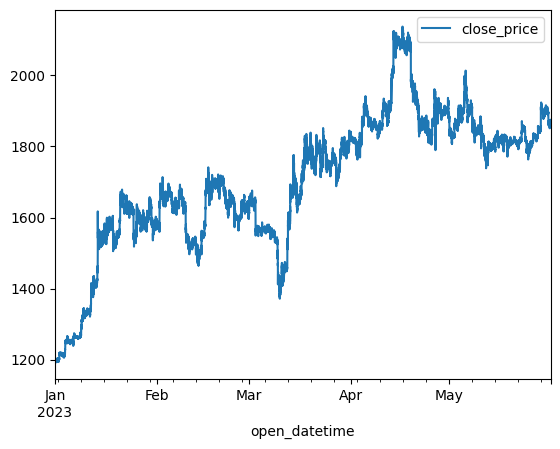

In [113]:
k_lines.plot.line(use_index=True)

In [114]:
features = k_lines[k_lines.columns]

features["past_close_price"] = features["close_price"].shift(15)
features["future_close_price"] = features["close_price"].shift(-15)
features["past_close_price_ratio"] = features["close_price"] / features["past_close_price"]
features["future_close_price_ratio"] = features["future_close_price"] / features["close_price"]

features.dropna(inplace=True)

display(features)

,close_price,past_close_price,future_close_price,past_close_price_ratio,future_close_price_ratio
open_datetime,,,,,
2023-01-01 00:15:00,1194.25,1196.03,1196.35,0.998512,1.001758
2023-01-01 00:16:00,1194.72,1196.03,1196.32,0.998905,1.001339
2023-01-01 00:17:00,1195.14,1195.75,1195.54,0.999490,1.000335
2023-01-01 00:18:00,1195.51,1195.80,1195.51,0.999757,1.000000
2023-01-01 00:19:00,1196.00,1196.29,1194.39,0.999758,0.998654
...,...,...,...,...,...
2023-05-31 23:40:00,1871.19,1870.02,1874.41,1.000626,1.001721
2023-05-31 23:41:00,1870.72,1869.47,1872.80,1.000669,1.001112
2023-05-31 23:42:00,1871.30,1870.24,1872.84,1.000567,1.000823


<Axes: xlabel='close_price', ylabel='future_close_price'>

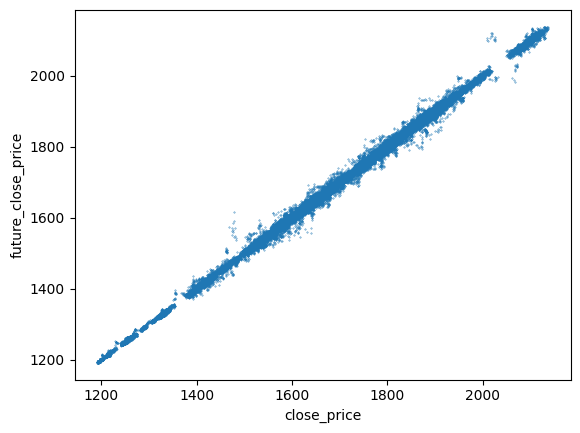

In [115]:
features.plot.scatter(x="close_price", y="future_close_price", s=0.1)

<Axes: ylabel='Frequency'>

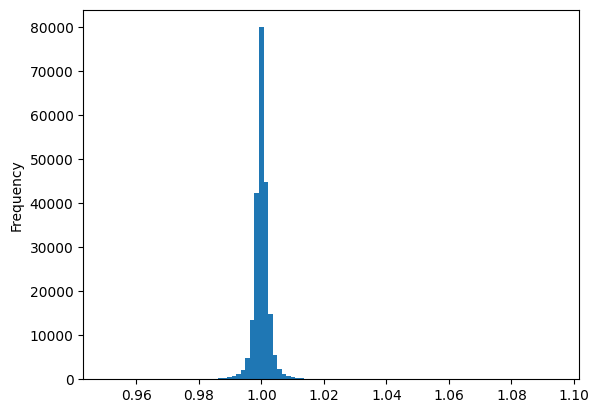

In [116]:
features["future_close_price_ratio"].plot.hist(bins=100)

<Axes: xlabel='close_price', ylabel='future_close_price_ratio'>

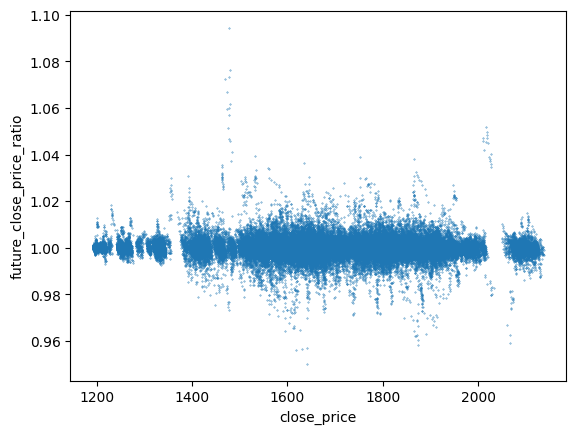

In [117]:
features.plot.scatter(x="close_price", y="future_close_price_ratio", s=0.1)

<Axes: xlabel='past_close_price_ratio', ylabel='future_close_price_ratio'>

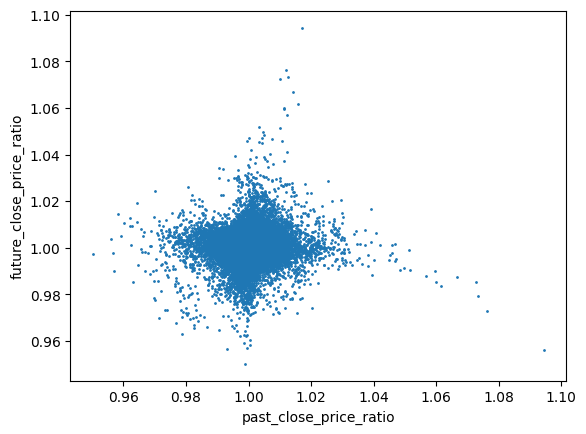

In [118]:
features.plot.scatter(x="past_close_price_ratio", y="future_close_price_ratio", s=1)